In [83]:
from matplotlib import pyplot as plt
from glob import glob
import os
import dask.array as da
import pandas as pd
import re
from multiprocessing import Pool
import yaml
import uuid
import sqlite3
from tqdm import tqdm

In [47]:
uuid.uuid4().hex

'469c625afc5f40c7a1b37c71d562ab17'

In [2]:


def find_big_nd2(path, out, pattern="*.nd2", notendpattern="zarr"):
    # print(path)
    flist = glob(os.path.join(path, pattern))
    if flist:
        print(f"->{os.path.getsize(flist[0])/1e9:.2f}GB, {flist[0]}")
        out.append(flist[0])
    for p in glob(os.path.join(path, "*")):
        if os.path.isdir(p) and not p.endswith(notendpattern):
            find_big_nd2(p, out, pattern=pattern, notendpattern=notendpattern)

In [3]:
out = []
find_big_nd2("/home/aaristov/Multicell/Lena/", out)

print(f"Total entries: {len(out)}")

sizes = map(os.path.getsize, out)

total_GB = sum(sizes)/1e9

print(f"total_GB: {total_GB}")

->464.25GB, /home/aaristov/Multicell/Lena/new_data/K.pneumoniae/20220429-klebsiella_cipro-6_samples_LB/00h-4-samples-timelapse-30min-BF-CF_TRITC001.nd2
->648.68GB, /home/aaristov/Multicell/Lena/new_data/K.pneumoniae/20220505-klebsiella_cipro-6_samples_LB/00h-timelapse-30min-BF-CF_TRITC-CF_FITC-WF-TRITC.nd2
->648.68GB, /home/aaristov/Multicell/Lena/new_data/K.pneumoniae/20220504-klebsiella_cipro-6_samples_LB/00h-timelapse-30min-BF-CF_TRITC-CF_FITC-WF-TRITC.nd2
->3.13GB, /home/aaristov/Multicell/Lena/new_data/MOPS_MIC_timelapse/20210622-MIC-load/10ng-TRITC.nd2
->0.66GB, /home/aaristov/Multicell/Lena/new_data/MOPS_MIC_timelapse/20211220-MIC/day2/08ng-BF-TRITC.nd2
->1.05GB, /home/aaristov/Multicell/Lena/new_data/MOPS_MIC_timelapse/20211220-MIC/day2/movies-24h/32ng-25fps-1.nd2
->9.42GB, /home/aaristov/Multicell/Lena/new_data/MOPS_MIC_timelapse/20211220-MIC/low OD/00ng-TRITC.nd2
->6.95GB, /home/aaristov/Multicell/Lena/new_data/MOPS_MIC_timelapse/20211220-MIC/timelapse/00ng-timelapse-TRITC-30

In [6]:
out = []
find_big_nd2("/home/aaristov/Multicell/Lena/new_data/E.coli/", out,pattern="day2/*aligned.zarr", notendpattern="zzzz")

print(f"Total entries: {len(out)}")

sizes = map(os.path.getsize, out)

total_GB = sum(sizes)/1e9

print(f"total_GB: {total_GB}")

->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/10cells/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/20cells/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220531-MIC-e.coli-cipro/2ndexp/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220531-MIC-e.coli-cipro/1stexp/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20230131-ecoli-cipro-1/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20230131-ecoli-cipro-2/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220822-e.coli-cipro/day2/BF_TRITC_aligned.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220815-e.coli-cipro/day2/BF_TRITC_aligned.zarr


In [11]:
centers = pd.read_csv(
    "/home/aaristov/.anchor-droplet-chip/data/centers_bin16.csv", 
    index_col=0
).values * 8

centers

array([[  895.29317269,  1460.89424364],
       [  894.96741855,  1997.51378446],
       [  895.59689922,  2529.15762274],
       [  895.59689922,  3065.15762274],
       [  895.86086957,  3604.65093168],
       [  895.61145704,  4133.16064757],
       [  895.86086957,  4676.65093168],
       [  896.38854296,  5205.16064757],
       [  896.27727856,  5744.5237484 ],
       [  895.57948718,  6272.38974359],
       [  896.5286783 ,  6813.02743142],
       [  896.7960199 ,  7348.76616915],
       [  897.15817694,  7884.50402145],
       [  897.52242424,  8424.96      ],
       [  896.85561497,  8948.75935829],
       [  897.03258145,  9485.51378446],
       [  898.72405063, 10020.92151899],
       [  898.18915511, 10557.57881463],
       [  897.51874244, 11096.99637243],
       [  898.73417722, 12173.63037975],
       [  897.25064599, 12704.37209302],
       [  897.20207254, 13233.37823834],
       [  896.68041237, 13768.89690722],
       [  896.92467532, 14305.64155844],
       [  896.56

In [9]:
size = 300

In [16]:

def crop2d(img, center: tuple, size: int = size):
    im = img[
        ...,
        int(center[0]) - size // 2 : int(center[0]) + size // 2,
        int(center[1]) - size // 2 : int(center[1]) + size // 2,
    ]
    return im

def get_crops(path_to_zarr, centers=centers, size=size):
    date = (re.compile("[0-9]{8}").findall(path_to_zarr)[0])
    data = da.from_zarr(path_to_zarr+"/0/")
    print(f"{date}: {data.shape} \n")
    if not data.shape == (6, 3, 7152, 22192):
        return
    crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
    da.to_zarr(crops, ppp := path_to_zarr.replace(".zarr", ".crops.zarr"))
    print(f"Saved {crops.shape} to {ppp}")
    return crops

In [17]:
try:
    p = Pool(8)
    all_crops = p.map(get_crops, out)
except Exception as e:
    print(e)
finally:
    p.close()

20220829: (6, 3, 7152, 22192) 
20220531: (6, 3, 7152, 22192) 
20220831: (6, 3, 7152, 22192) 
20220526: (6, 3, 7152, 22192) 
20220602: (6, 3, 6544, 20896) 
20220822: (6, 3, 7152, 22192) 
20230131: (6, 3, 7152, 22192) 

20220519: (6, 3, 7152, 22192) 







20220614: (6, 3, 7152, 22192) 



/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 138
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 138
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 138
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 138
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Incre

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20230131-ecoli-cipro-1/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220531-MIC-e.coli-cipro/2ndexp/day2/BF_TRITC_aligned.crops.zarr
20230131: (6, 3, 7152, 22192) 

20220531: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/10cells/day2/BF_TRITC_aligned.crops.zarr
20220526: (6, 3, 7152, 22192) 



/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220831-ecoli-amp/day2/BF_TRITC_aligned.crops.zarr
20220519: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220519-MIC-e.coli-amp-LB/20cells/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220614-MIC-e.coli-amp-LB-1/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220829-ecoli-amp/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220822-e.coli-cipro/day2/BF_TRITC_aligned.crops.zarr
20220614: (6, 3, 7152, 22192) 

20220518: (6, 3, 7152, 22192) 

20220827: (6, 3, 7152, 22192) 

20220815: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20230131-ecoli-ci

/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 138
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()



Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220531-MIC-e.coli-cipro/1stexp/day2/BF_TRITC_aligned.crops.zarr20221101: (6, 3, 7152, 22192) 



/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 138
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/20cells/day2/BF_TRITC_aligned.crops.zarr
20230110: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220519-MIC-e.coli-amp-LB/10cells/day2/BF_TRITC_aligned.crops.zarr
20220921: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220518-MIC-e.coli-amp-LB/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Gentamicin/20230110-e.coli-genta/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Ampicillin/20220614-MIC-e.coli-amp-LB-2/day2/BF_TRITC_aligned.crops.zarr
20220524: (6, 3, 7152, 22192) 

20221012: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220815-e.coli-cipro/day2

/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


20220602: (6, 3, 7152, 22192) 

20220518: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Gentamicin/20230105-ecoli-genta-2/day2/BF_TRITC_aligned.crops.zarr
20220628: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Gentamicin/20230105-ecoli-genta/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Gentamicin/20230110-e.coli-genta-2/day2/BF_TRITC_aligned.crops.zarr
20221031: (6, 3, 7152, 22192) 

20230313: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Meropenem/20220921-e.coli-mero/day2/BF_TRITC_aligned.crops.zarr
20230313: (6, 3, 7152, 22192) 



/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Meropenem/20221012-ecoli-mero/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20220602-MIC-e.coli-chp-LB/day2/BF_TRITC_aligned.crops.zarr
20230111: (6, 3, 7152, 22192) 



/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


20220628: (6, 3, 7152, 22192) 


20221031: (6, 3, 7152, 22192) 
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20220524-MIC-e.coli-chp-LB/day2/BF_TRITC_aligned.crops.zarr
20221013: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20220518-MIC-e.coli-chp-LB/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20230313-ecoli-chp-2/day2/BF_TRITC_aligned.crops.zarr
20221012: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20230313-ecoli-chp-1/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20230111-ecoli-chp-2/day2/BF_TRITC_aligned.crops.zarr
20230111: (6, 3, 7152, 22192) 

20220622: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/

/tmp/ipykernel_3050344/1509465046.py:15: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20230111-ecoli-chp/day2/BF_TRITC_aligned.crops.zarr
20221102: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20230221-ecoli-chp-1/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20221012-ecoli-chp/day2/BF_TRITC_aligned.crops.zarr
Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Tetracycline/20230315-ecoli/20230315-ecoli-2/day2/BF_TRITC_aligned.crops.zarr
20230315: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20220622-MIC-e.coli-chp-LB-1/day2/BF_TRITC_aligned.crops.zarr
20221122: (6, 3, 7152, 22192) 

Saved (500, 6, 2, 300, 300) to /home/aaristov/Multicell/Lena/new_data/E.coli/Chloramphenicol/20221102-ecoli-chp1/day2/BF_TRITC_aligned.crops.zarr
Saved (500,

In [32]:
crops_zarr_paths = []
find_big_nd2("/home/aaristov/Multicell/Lena/new_data/", crops_zarr_paths, "*.crops.zarr", notendpattern="BBB")

->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/10cells/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/20cells/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220531-MIC-e.coli-cipro/2ndexp/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220531-MIC-e.coli-cipro/1stexp/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20230131-ecoli-cipro-1/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20230131-ecoli-cipro-2/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/20220822-e.coli-cipro/day2/BF_TRITC_aligned.crops.zarr
->0.00GB, /home/aaristov/Multicell/Lena/new_data/E.coli/Cirpofloxacin/2022081

In [71]:
prefix = "/home/aaristov/Multicell/"


In [75]:
def get_concentrations(path_zarr):
    return yaml.load(open(os.path.dirname(path_zarr)+"/../concentrations.yaml"), yaml.Loader)

In [94]:
def get_path_meta_table(path, prefix=prefix):
    bac, ab, date = re.compile(prefix + r"(.*)/(.*)/([0-9]{8}).*").findall(path)[0]
    data_path = path[len(prefix):]
    concentrations = get_concentrations(path)
    # print(concentrations)
    dataset_id = uuid.uuid4().hex
    ccc = []
    for i, c in enumerate(concentrations["concentrations"]):
        ccc.append({"id":uuid.uuid4().hex, "dataset_id": dataset_id, "chip_id": i, "concentration": c,})
    return {
        "id": dataset_id, 
        "antibiotic_type": ab, 
        "date": f"{date[:4]}-{date[4:6]}-{date[6:]}", 
        "path": data_path,
        "unit": concentrations["units"],
        "concentrations": ccc
    }

In [96]:
datasets = list(map(get_path_meta_table, tqdm(crops_zarr_paths)))
datasets[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 101.94it/s]


{'id': 'a90e23e1a24e4646b0439449aef8e2f2',
 'antibiotic_type': 'Cirpofloxacin',
 'date': '2022-05-26',
 'path': 'Lena/new_data/E.coli/Cirpofloxacin/20220526-MIC-e.coli-cipro/10cells/day2/BF_TRITC_aligned.crops.zarr',
 'unit': 'ng_mL',
 'concentrations': [{'id': '4f3d1eb4fff648c382dff0c063d31a0b',
   'dataset_id': 'a90e23e1a24e4646b0439449aef8e2f2',
   'chip_id': 0,
   'concentration': 0},
  {'id': 'bb4ec2c0669c45da9754dd84d041cdd4',
   'dataset_id': 'a90e23e1a24e4646b0439449aef8e2f2',
   'chip_id': 1,
   'concentration': 4},
  {'id': '9f48411905e2469f83cd8bf97f0c7446',
   'dataset_id': 'a90e23e1a24e4646b0439449aef8e2f2',
   'chip_id': 2,
   'concentration': 8},
  {'id': 'f947bd7204a74276b67a020e37f92f1d',
   'dataset_id': 'a90e23e1a24e4646b0439449aef8e2f2',
   'chip_id': 3,
   'concentration': 16},
  {'id': '26cae507f9ee469083f0695bb2307ba5',
   'dataset_id': 'a90e23e1a24e4646b0439449aef8e2f2',
   'chip_id': 4,
   'concentration': 32},
  {'id': '67671783c183441ea551dfee08369517',
   'd

In [76]:
get_concentrations(crops_zarr_paths[0])

{'concentrations': [0, 4, 8, 16, 32, 64], 'units': 'ng_mL'}

In [97]:
# Connect to the database
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

schema = '''

DROP TABLE datasets;
DROP TABLE chips;

CREATE TABLE datasets (
  id CHAR(32) PRIMARY KEY ,
  path VARCHAR(255) NOT NULL,
  date DATE NOT NULL,
  antibiotic_type VARCHAR(50) NOT NULL,
  unit VARCHAR(5)
);

CREATE TABLE chips (
  id CHAR(32) PRIMARY KEY ,
  dataset_id INT NOT NULL,
  chip_id INT NOT NULL,
  concentration FLOAT NOT NULL,
  FOREIGN KEY (dataset_id) REFERENCES datasets(id)
);
'''
cursor.executescript(schema)
# Define a dictionary with the data to insert

# Insert the data into the datasets table
for data in datasets:
    cursor.execute("INSERT INTO datasets (id, path, date, antibiotic_type, unit) VALUES (:id, :path, :date, :antibiotic_type, :unit)", data)
    
    chip_ids = [uuid.uuid4().hex for _ in range(6)]

    # Insert the chip data into the chips table
    for chip in data["concentrations"]:
        cursor.execute("INSERT INTO chips (id, dataset_id, chip_id, concentration) VALUES (:id, :dataset_id, :chip_id, :concentration)", chip)

# Commit the changes
conn.commit()

# Close the database connection
conn.close()

In [26]:
line = f"{prefix}(.*)/([0-9]{8}).*"
line

'/home/aaristov/Multicell/Lena/new_data/(.*)/([0-9]8).*'

In [19]:
all_crops[0][0,0,0]

dask.array<getitem, shape=(300, 300), dtype=uint16, chunksize=(300, 300), chunktype=numpy.ndarray>

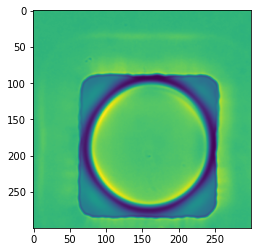

In [103]:
plt.imshow(all_crops[10, 30, 0, 0])

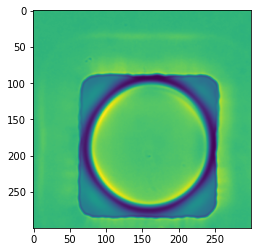

In [103]:
plt.imshow(all_crops[10, 30, 0, 0])

In [74]:
crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()
crops

/tmp/ipykernel_2767961/3016171686.py:1: PerformanceWarning: Increasing number of chunks by factor of 66
  crops = da.stack(map(lambda c: crop2d(data[:,:2], c, 300), centers)).rechunk()


dask.array<rechunk-merge, shape=(500, 6, 2, 300, 300), dtype=uint16, chunksize=(50, 6, 2, 300, 300), chunktype=numpy.ndarray>